In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/AIP/PascalVOC.zip

In [ ]:
import torch
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from torch import optim
from tqdm.auto import tqdm
import cv2
from torchvision.models import segmentation
import torchvision.transforms.functional as F


In [ ]:
# Load the FCN_ResNet50 model
model = segmentation.fcn_resnet50(pretrained=True)

In [ ]:

def prediction_accuracy(img_path, mask_path, model):

  # Load and preprocess the image
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_tensor = transforms.ToTensor()(img)
  img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
  img_tensor = img_tensor.unsqueeze(0)

  # Make the prediction
  model.eval()
  with torch.no_grad():
      output = model(img_tensor)['out']
      
  output = output.argmax(1).squeeze().detach().cpu().numpy()

  # Create a color map for the segmentation labels
  colors = np.array([ (0, 0, 0),  # background
                (128, 0, 0), # aeroplane
                (0, 128, 0), # bicycle
                (128, 128, 0), # bird
                (0, 0, 128), # boat
                (128, 0, 128), # bottle
                (0, 128, 128), # bus 
                (128, 128, 128), # car
                (64, 0, 0), # cat
                (192, 0, 0), # chair
                (64, 128, 0), # cow
                (192, 128, 0), # dining table
                (64, 0, 128), # dog
                (192, 0, 128), # horse
                (64, 128, 128), # motorbike
                (192, 128, 128), # person
                (0, 64, 0), # potted plant
                (128, 64, 0), # sheep
                (0, 192, 0), # sofa
                (128, 192, 0), # train
                (0, 64, 128)]) #

  colored_output = colors[output]

  output = colored_output

  # Load the ground truth label
  label = cv2.imread(mask_path)
  label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

  # Calculate pixel accuracy
  pixel_acc = (output == label).astype(int).sum() / label.size
  # print(f"Pixel Accuracy: {pixel_acc:.4f}")

  # Calculate mIoU
  iou = []
  for class_id in colors:
      true_positives = ((output == class_id) & (label == class_id)).sum()
      false_positives = ((output == class_id) & (label != class_id)).sum()
      false_negatives = ((output != class_id) & (label == class_id)).sum()

      if true_positives + false_positives + false_negatives == 0:
          iou.append(0)
      else:
          iou.append(true_positives / (true_positives + false_positives + false_negatives))

  miou = np.mean(iou)

  # print("mIoU: {:.4f}".format(miou))
  return pixel_acc, miou
  # print("\nMaximum Intensity in Output of fcn_resnet50 after argmax: ",np.max(output))


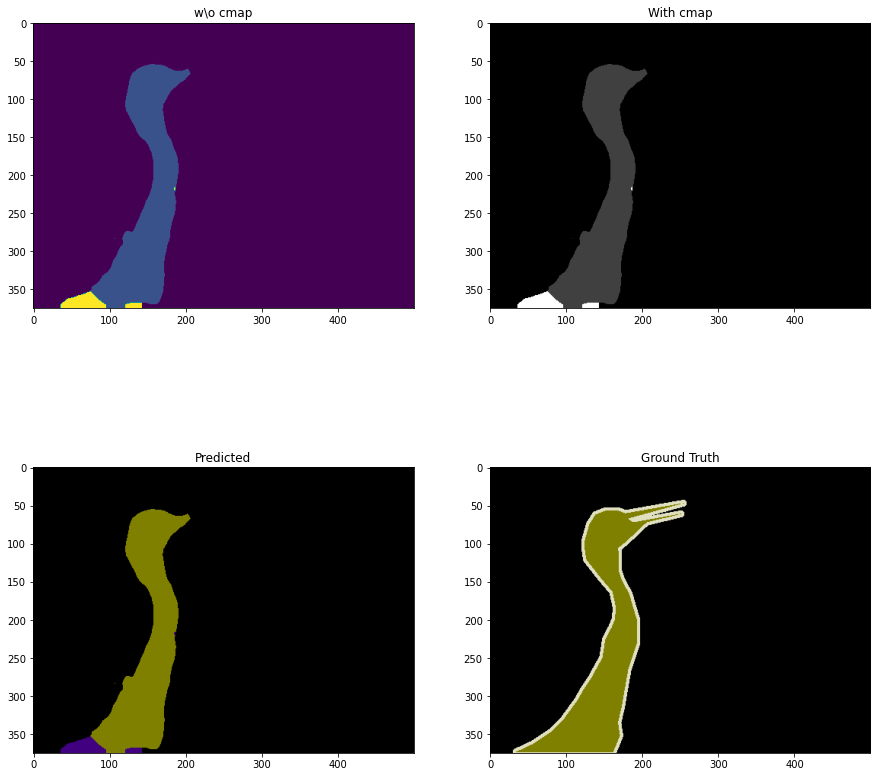


Maximum Intensity in Output of fcn_resnet50 after argmax:  12
NOTE: Although the maximum intensity is in range 0-20 (due to argmax along the 21 classes) but due to default matplotlib normalization higher intensity is also observed in the plot
Pixel Accuracy: 0.9677
mIoU: 0.9347


In [ ]:
print("\nMaximum Intensity in Output of fcn_resnet50 after argmax: ",np.max(output))
print("NOTE: Although the maximum intensity is in range 0-20 (due to argmax along the 21 classes) but due to default matplotlib normalization higher intensity is also observed in the plot")
prediction_accuracy("/content/PascalVOC/test/Images/000068.jpg", "/content/PascalVOC/test/Annotations/000068.png", model)
path = "000068.png"
Pixel_Accuracy, mIoU = prediction_accuracy(f"/content/PascalVOC/test/Images/{path}.jpg",f"/content/PascalVOC/test/Annotations/{path}.png", model)
print("Pixel Accuracy: ", Pixel_Accuracy)
print("mIoU", mIoU)

In [ ]:
path = "000175.png"
Pixel_Accuracy, mIoU = prediction_accuracy(f"/content/PascalVOC/test/Images/{path}.jpg",f"/content/PascalVOC/test/Annotations/{path}.png", model)
print("Pixel Accuracy: ", Pixel_Accuracy)
print("mIoU", mIoU)

Pixel Accuracy: 0.9146
mIoU: 0.8286


In [ ]:
annotation_name = []
for a, b, c in os.walk("/content/PascalVOC/test/Annotations"):
  annotation_name = c
anno = []
for string in annotation_name:
  anno1 = string.replace(".png", "")
  anno.append(anno1)

In [ ]:
pixel_acc_cumulative = 0
mIoU_cumulative = 0
for image_name in tqdm(anno):
  a, b = prediction_accuracy(f"/content/PascalVOC/test/Images/{image_name}.jpg",f"/content/PascalVOC/test/Annotations/{image_name}.png", model)
  pixel_acc_cumulative = pixel_acc_cumulative + a
  mIoU_cumulative = mIoU_cumulative + b
print(f"Average Pixel Accuracy over Test set: {pixel_acc_cumulative/len(anno):.5f}")
print(f"Average mIoU over Test set: {mIoU_cumulative/len(anno):.5f}")

Average Pixel Accuracy over Test set: 0.90612
Average mIoU over Test set: 0.84320
